# MNIST target model training

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from models.target import MNISTConvTarget

In [2]:
WEIGHTS_DIR = 'weights'

BASE_FILENAME = 'mnist_conv_target'

In [3]:
import os

if not os.path.isdir(WEIGHTS_DIR):
    os.makedirs(WEIGHTS_DIR)

## MNIST

### Data loading and preprocessing

Load the MNIST training and test set images:

In [4]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
print(f'training set: {train_images.shape}, {train_labels.shape}')
print(f'test set: {test_images.shape}, {test_labels.shape}')

training set: (60000, 28, 28), (60000,)
test set: (10000, 28, 28), (10000,)


Reshape the images to $28 \times 28 \times 1$ and normalize them to $[-1, 1]$:

In [5]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5
train_images.shape

(60000, 28, 28, 1)

In [6]:
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')
test_images = (test_images - 127.5) / 127.5
test_images.shape

(10000, 28, 28, 1)

Convert the label integers to binary class matrices (one-hot encoding):

In [7]:
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=10)
train_labels.shape

(60000, 10)

In [8]:
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=10)
test_labels.shape

(10000, 10)

### MNISTConvTarget

`MNISTConvTarget` is a CNN-based MNIST classifier:

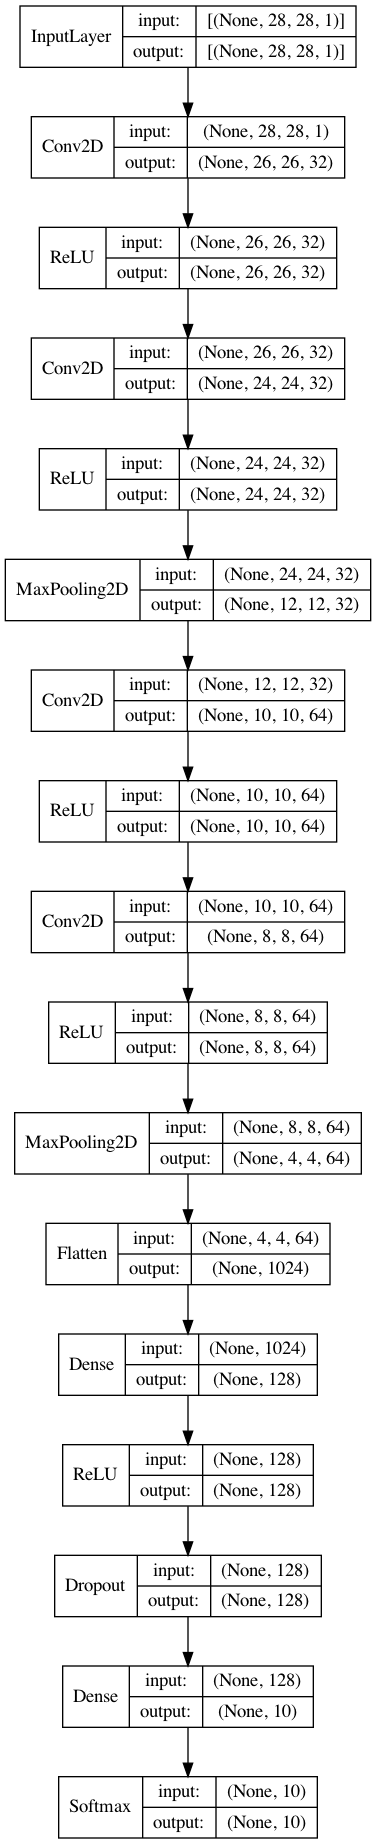

In [9]:
target = MNISTConvTarget()
tf.keras.utils.plot_model(target.model, show_shapes=True, show_layer_names=False)

In [10]:
target.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

#### Training

In [11]:
history = target.fit(
    train_images, train_labels,
    epochs=6,
    batch_size=128,
    validation_split=.1
)

Epoch 1/6
422/422 [==============================] - 47s 109ms/step - loss: 0.2410 - categorical_accuracy: 0.9239 - val_loss: 0.0492 - val_categorical_accuracy: 0.9838

In [12]:
import time

weights_path = f'{WEIGHTS_DIR}/{BASE_FILENAME}_{time.strftime("%Y%m%d%H%M%S")}.h5'
target.save_weights(weights_path)

Plot the loss and accuracy on the training and validation sets over training epochs:

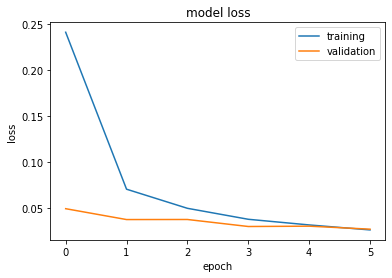

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')

plt.show()

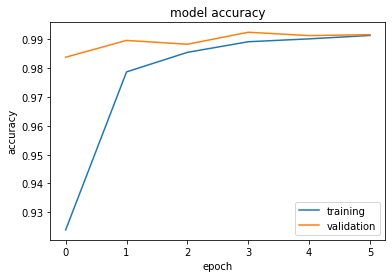

In [14]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')

plt.show()

#### Test set performance

Check the model's loss and accuracy on the test set:

In [15]:
loss, accuracy = target.evaluate(test_images, test_labels, verbose=False)
print(f'test loss: {loss:.3}')
print(f'test accuracy: {accuracy:.3}')

test loss: 0.0208
test accuracy: 0.994


Plot the confusion matrix:

In [16]:
probs = target.predict(test_images)

cm = tf.math.confusion_matrix(
    labels=test_labels.argmax(axis=1),
    predictions=probs.argmax(axis=1)
).numpy()

In [17]:
cm_norm = np.around(cm / cm.sum(axis=1), decimals=2)

classes = list(range(10))
cm_df = pd.DataFrame(cm_norm, index=classes, columns=classes)

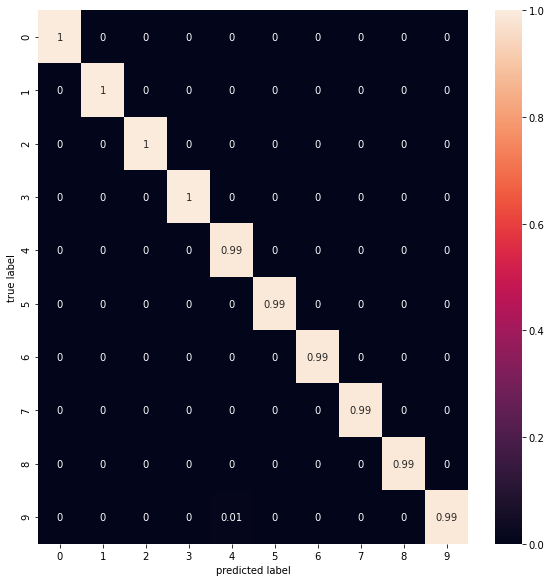

In [18]:
fig = plt.figure(figsize=(8, 8))
sns.heatmap(cm_df, annot=True)

plt.tight_layout()
plt.ylabel('true label')
plt.xlabel('predicted label')
plt.show()
